In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 1000

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

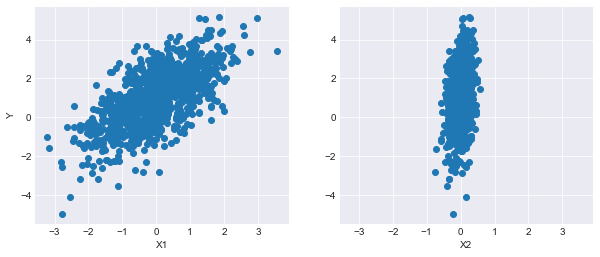

In [3]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=100)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '3696' (I am process '15044')


In [5]:
with basic_model:
    # draw 5000 posterior samples
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████████████████████████████████| 11000/11000 [00:27<00:00, 398.04draws/s]


WOW zero divergences

C:\Users\Hp\anaconda\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


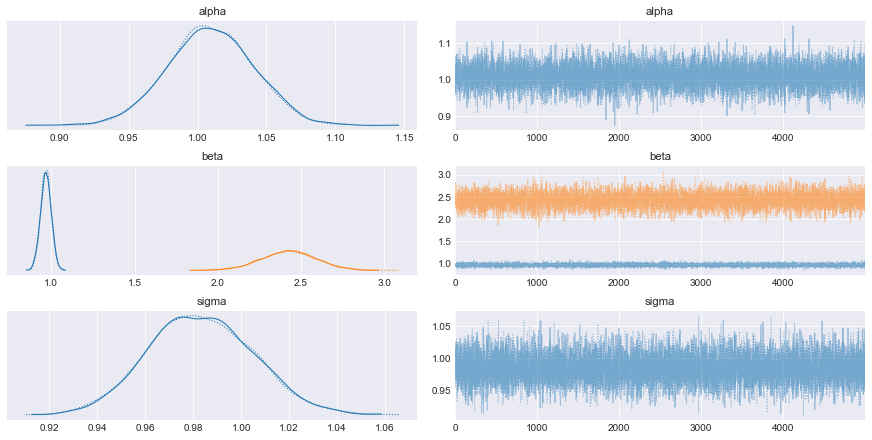

In [6]:
pm.traceplot(trace);

Plots are good and seems good to go.

C:\Users\Hp\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 648x504 with 0 Axes>

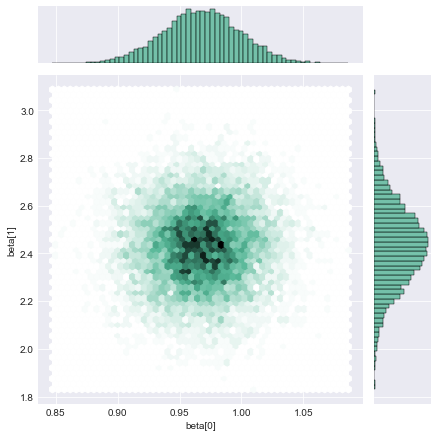

C:\Users\Hp\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 648x504 with 0 Axes>

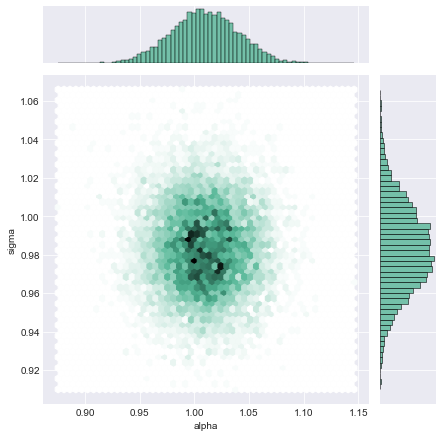

In [7]:
import seaborn as sns
plt.figure(figsize=(9,7))
sns.jointplot(trace['beta'][:,0], trace['beta'][:,1], kind="hex", color="#4CB391")
plt.xlabel("beta[0]")
plt.ylabel("beta[1]");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['alpha'], trace['sigma'], kind="hex", color="#4CB391")
plt.xlabel("alpha")
plt.ylabel("sigma");
plt.show()

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

C:\Users\Hp\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


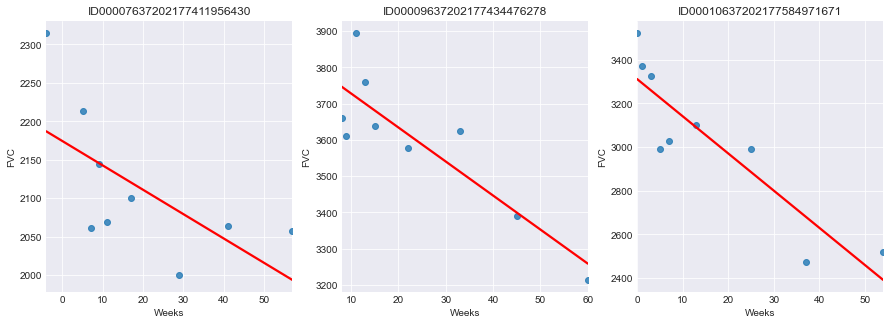

In [10]:
def chart(patient_id, ax):
    data = train[train['Patient'] == patient_id]
    x = data['Weeks']
    y = data['FVC']
    ax.set_title(patient_id)
    ax = sns.regplot(x, y, ax=ax, ci=None, line_kws={'color':'red'})
    

f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart('ID00007637202177411956430', axes[0])
chart('ID00009637202177434476278', axes[1])
chart('ID00010637202177584971671', axes[2])

In [12]:
# Very simple pre-processing: adding patient class
def patient_class(row):
    if row['Sex'] == 'Male':
        if row['SmokingStatus'] == 'Currently smokes':
            return 0
        elif row['SmokingStatus'] == 'Ex-smoker':
            return 1
        elif row['SmokingStatus'] == 'Never smoked':
            return 2
    else:
        if row['SmokingStatus'] == 'Currently smokes':
            return 3
        elif row['SmokingStatus'] == 'Ex-smoker':
            return 4
        elif row['SmokingStatus'] == 'Never smoked':
            return 5

train['Class'] = train.apply(patient_class, axis=1)

In [13]:
# Very simple pre-processing: adding FVC and week baselines
aux = train[['Patient', 'Weeks']].groupby('Patient')\
    .min().reset_index()
aux = pd.merge(aux, train[['Patient', 'Weeks', 'FVC']], how='left', 
               on=['Patient', 'Weeks'])
aux = aux.groupby('Patient').mean().reset_index()
aux['Weeks'] = aux['Weeks'].astype(int)
aux['FVC'] = aux['FVC'].astype(int)
train = pd.merge(train, aux, how='left', on='Patient', suffixes=('', '_base'))

In [14]:
# Very simple pre-processing: creating patient indexes
le = preprocessing.LabelEncoder()
train['PatientID'] = le.fit_transform(train['Patient'])

patients = train[['Patient', 'PatientID', 'Age', 'Class', 'Weeks_base', 'FVC_base']].drop_duplicates()
fvc_data = train[['Patient', 'PatientID', 'Weeks', 'FVC']]

patients.head()

,Patient,PatientID,Age,Class,Weeks_base,FVC_base
0,ID00007637202177411956430,0,79,1,-4,2315
9,ID00009637202177434476278,1,69,1,8,3660
18,ID00010637202177584971671,2,60,1,0,3523
27,ID00011637202177653955184,3,72,1,6,3326
36,ID00012637202177665765362,4,65,2,33,3418


In [15]:
FVC_b = patients['FVC_base'].values
w_b = patients['Weeks_base'].values
age = patients['Age'].values
patient_class = patients['Class'].values

t = fvc_data['Weeks'].values
FVC_obs = fvc_data['FVC'].values
patient_id = fvc_data['PatientID'].values

with pm.Model() as hierarchical_model:
    # Hyperpriors for Alpha
    beta_int = pm.Normal('beta_int', 0, sigma=100)
    sigma_int = pm.HalfNormal('sigma_int', 100)
    
    # Alpha
    mu_alpha = FVC_b + beta_int * w_b
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_int, 
                      shape=train['Patient'].nunique())
    
    # Hyperpriors for Beta
    sigma_s = pm.HalfNormal('sigma_s', 100)
    alpha_s = pm.Normal('alpha_s', 0, sigma=100)
    beta_cs = pm.Normal('beta_cs', 0, sigma=100, shape=6)
    
    # Beta
    mu_beta = alpha_s + age * beta_cs[patient_class]
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_s,
                     shape=train['Patient'].nunique())
    
    # Model variance
    sigma = pm.HalfNormal('sigma', 200)
    
    # Model estimate
    FVC_est = alpha[patient_id] + beta[patient_id] * t
    
    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu=FVC_est,
                          sigma=sigma, observed=FVC_obs)

In [ ]:
# Inference button (TM)!
with hierarchical_model:
    trace = pm.sample(2000, tune=2000, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, beta_cs, alpha_s, sigma_s, alpha, sigma_int, beta_int]
Sampling 2 chains, 0 divergences:  74%|██████████████████████████████▏          | 5901/8000 [04:08<00:59, 35.39draws/s]

In [ ]:
with hierarchical_model:
    pm.traceplot(trace);

In [ ]:
def chart(patient_id, ax):
    data = train[train['Patient'] == patient_id]
    x = data['Weeks']
    y = data['FVC']
    ax.set_title(patient_id)
    ax = sns.regplot(x, y, ax=ax, ci=None, line_kws={'color':'red'})
    
    x2 = np.arange(-12, 133, step=0.1)
    
    pid = patients[patients['Patient'] == patient_id]['PatientID'].values[0]
    for sample in range(100):
        alpha = trace['alpha'][sample, pid]
        beta = trace['beta'][sample, pid]
        sigma = trace['sigma'][sample]
        y2 = alpha + beta * x2
        ax.plot(x2, y2, linewidth=0.1, color='green')
        y2 = alpha + beta * x2 + sigma
        ax.plot(x2, y2, linewidth=0.1, color='yellow')
        y2 = alpha + beta * x2 - sigma
        ax.plot(x2, y2, linewidth=0.1, color='yellow')

f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart('ID00007637202177411956430', axes[0])
chart('ID00009637202177434476278', axes[1])
chart('ID00010637202177584971671', axes[2])

In [ ]:
# Very simple pre-processing: adding patient class
def patient_class(row):
    if row['Sex'] == 'Male':
        if row['SmokingStatus'] == 'Currently smokes':
            return 0
        elif row['SmokingStatus'] == 'Ex-smoker':
            return 1
        elif row['SmokingStatus'] == 'Never smoked':
            return 2
    else:
        if row['SmokingStatus'] == 'Currently smokes':
            return 3
        elif row['SmokingStatus'] == 'Ex-smoker':
            return 4
        elif row['SmokingStatus'] == 'Never smoked':
            return 5

test['Class'] = test.apply(patient_class, axis=1)
test = test.rename(columns={'FVC': 'FVC_base', 'Weeks': 'Weeks_base'})
test.head()

In [ ]:
# prepare submission dataset
submission = []
for i, patient in enumerate(test['Patient'].unique()):
    df = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC'])
    df['Weeks'] = np.arange(-12, 134)
    df['Patient'] = patient
    df['PatientID'] = i
    df['FVC'] = 0
    submission.append(df)
    
submission = pd.concat(submission).reset_index(drop=True)
submission.head()